## Coregistration of Satellite Image Data Sources

In this tutorial, you'll learn how to use [stackstac](https://stackstac.readthedocs.io/en/latest/) on Planetary Computer to coregister (align) two spatially overlapping raster images from Sentinel-2 Level 2A and Landsat Collection 2 Level-2 into a single dataset. You will then calculate the [Normalized difference vegetation index (NDVI)](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) of the resulting dataset and compare it to the NDVI based on the original data.

This tutorial covers the following steps:

- Searching for and loading data from the Planetary Computer's [STAC endpoint](../quickstarts/reading-stac.ipynb)
- Reprojecting and resampling [Sentinel-2 Level-2A](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a) and [Landsat Collection 2 Level-2
](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2) data to use a common resolution and coordinate system
- Croping to the region of interest and aligning Sentinel and Landsat data into a single dataset
- Calculating and comparing NDVIs with [xarray-spatial](https://xarray-spatial.org/index.html)

In [1]:
import planetary_computer as pc

import numpy as np
import pandas as pd
import xarray as xr
import stackstac
import pystac_client
import rasterio
import xrspatial.multispectral as ms

### Preparation: create a local Dask cluster

In this tutorial, you'll be using a small dataset. Create a local Dask cluster to hold your data.

In [2]:
from dask.distributed import Client

client = Client()
print(f"/proxy/{client.scheduler_info()['services']['dashboard']}/status")

distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/PlanetaryComputerExamples/tutorials/dask-worker-space/worker-00ez62s2', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/PlanetaryComputerExamples/tutorials/dask-worker-space/worker-5rvnjypf', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/PlanetaryComputerExamples/tutorials/dask-worker-space/worker-q9q9vh0q', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/PlanetaryComputerExamples/tutorials/dask-worker-space/worker-40u3rhm1', purging


/proxy/8787/status


To follow the progress of your computations, you can [access the Dask Dashboard](https://planetarycomputer.microsoft.com/docs/quickstarts/scale-with-dask/#Open-the-dashboard) at the URL from the previous cell's output.

### Load matching Sentinel and Landsat datasets

The area of interest covers a small section of the Mississippi River, USA, near the Yazoo National Wildlife Refuge. The two datasets have different tiling boundaries, so scenes from one won't line up perfectly with scenes from the other.

We'll select a single Sentinel scene and then make a median mosaic of Landsat scenes overlapping with that Sentinel scene.

In [3]:
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [-91.92, 33.43],
            [-90.74, 33.41],
            [-90.76, 32.42],
            [-91.93, 32.44],
            [-91.92, 33.43],
        ]
    ],
}
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1"
)

sentinel_search = catalog.search(
    intersects=area_of_interest,
    datetime="2020-09-07/2020-09-08",
    collections=["sentinel-2-l2a"],
)

sentinel_item = next(sentinel_search.get_items())  # select the first item
sentinel_item = pc.sign(sentinel_item)

Now let's, use [pystac_client](https://pystac-client.readthedocs.io/en/latest/) to identify all matching Landsat images with a cloud coverage of less than 10 percent in September 2020 that overlap with that Sentinel scene's bounding box.

In [4]:
time_of_interest = "2020-09-01/2020-09-30"

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1"
)
search = catalog.search(
    collections=["landsat-c2-l2"],
    intersects=sentinel_item.geometry,
    datetime=time_of_interest,
    query={
        "eo:cloud_cover": {
            "lt": 10,
        }
    },
)

landsat_items = [pc.sign(item).to_dict() for item in search.get_items()]

### Match Sentinel and Landsat data properties

Let's start by loading the Sentinel data into an `xarray.DataArray` using its native [Coordinate Reference System (CRS)](https://gdal.org/tutorials/osr_api_tut.html) `epsg=32615` and a resolution of 100m.

In [5]:
sentinel_data = (
    (
        stackstac.stack(
            sentinel_item,
            resolution=100,
            assets=["B02", "B03", "B04", "B08"],  # blue, green, red, nir
        )
        .where(lambda x: x > 0, other=np.nan)  # sentinel-2 uses 0 as nodata
        .assign_coords(band=lambda x: x.common_name.rename("band"))  # use common names
    )
    .isel(time=0)
    .persist()
)

sentinel_data.spec, sentinel_data.resolution, sentinel_data.shape

(RasterSpec(epsg=32615, bounds=(699900, 3690200, 809800, 3800100), resolutions_xy=(100, 100)),
 100,
 (4, 1099, 1099))

Before coregistering data, you need to make sure that both data sets use the same resolution and the same CRS. Use `stackstac.stack` to set the `epsg` and `resolution` properties of your Landast data to match the CRS and resolution of your Sentinel data as you read it into xarray.

Translating data from one CRS to another is called reprojection. See [Reprojecting](reprojection.ipynb) to learn more.

In [6]:
landsat_data = (
    (
        stackstac.stack(
            landsat_items,
            resolution=sentinel_data.resolution,  # resample to Sentinel data resolution
            epsg=sentinel_data.spec.epsg,  # reporoject to CRS of Sentinel data
            bounds=sentinel_data.spec.bounds,  # set bounds to match Sentinel data
            assets=["blue", "green", "red", "nir08"],
            resampling=rasterio.enums.Resampling.bilinear,
        ).where(
            lambda x: x > 0, other=np.nan
        )  # landsat-c2-l2 uses 0 as nodata
    )
    .median(dim="time", keep_attrs=True)
    .persist()
)

landsat_data.spec, landsat_data.shape

(RasterSpec(epsg=32615, bounds=(699900, 3690200, 809800, 3800100), resolutions_xy=(100, 100)),
 (4, 1099, 1099))

Both the Sentinel and the Landsat data should now have the same raster spec information. To make sure, check whether their x and y coordinates match.

In [7]:
(landsat_data.x.data == sentinel_data.x.data).all()

True

In [8]:
(landsat_data.y.data == sentinel_data.y.data).all()

True

To display a preview of the two data sets, use the [xrspatial.multispectral.true_color](https://xarray-spatial.org/reference/_autosummary/xrspatial.multispectral.true_color.html) function with `sentinel_data` and `landsat_data`.

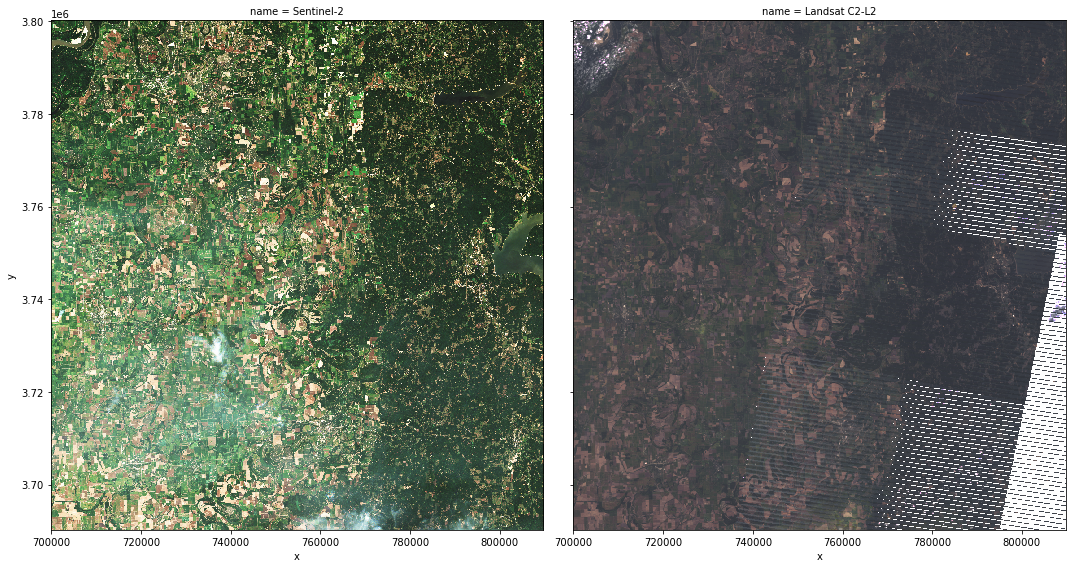

In [9]:
sentinel_image = ms.true_color(
    sentinel_data.sel(band="red"),
    sentinel_data.sel(band="green"),
    sentinel_data.sel(band="blue"),
    c=25,
    th=0.1,
    name="Sentinel-2",
)

landsat_image = ms.true_color(
    landsat_data.sel(band="red"),
    landsat_data.sel(band="green"),
    landsat_data.sel(band="blue"),
    c=15,
    th=0.1,
    name="Landsat C2-L2",
)

org_imgs = xr.concat(
    [sentinel_image, landsat_image],
    pd.Index([sentinel_image.name, landsat_image.name], name="name"),
)

org_imgs.plot.imshow(x="x", y="y", col="name", figsize=(15, 8));

### Coregister Sentinel and Landsat data into one dataset

Combine Sentinel and Landsat data into a single [xarray Dataset](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.html).

In [10]:
coregistration_data = xr.Dataset(
    data_vars=dict(
        sentinel=(["band", "y", "x"], sentinel_data.data),
        landsat=(["band", "y", "x"], landsat_data.data),
    ),
    coords=dict(
        x=sentinel_data.x.data,
        y=sentinel_data.y.data,
        band=sentinel_data.band.data,
    ),
    attrs=sentinel_data.attrs,  # both dataset have the same attributes
)

coregistration_data

<xarray.Dataset>
Dimensions:   (band: 4, y: 1099, x: 1099)
Coordinates:
  * x         (x) float64 6.999e+05 7e+05 7.001e+05 ... 8.096e+05 8.097e+05
  * y         (y) float64 3.8e+06 3.8e+06 3.8e+06 ... 3.69e+06 3.69e+06
  * band      (band) <U5 'blue' 'green' 'red' 'nir'
Data variables:
    sentinel  (band, y, x) float64 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    landsat   (band, y, x) float64 dask.array<chunksize=(1, 1099, 1099), meta=np.ndarray>
Attributes:
    spec:        RasterSpec(epsg=32615, bounds=(699900, 3690200, 809800, 3800...
    crs:         epsg:32615
    transform:   | 100.00, 0.00, 699900.00|\n| 0.00,-100.00, 3800100.00|\n| 0...
    resolution:  100

### Wrap-up: compare NDVI

Now let's compute NDVI on the coregistered dataset using [xrspatial.multispectral.ndvi](https://xarray-spatial.org/reference/_autosummary/xrspatial.multispectral.ndvi.html). We'll use the near-infrared band from Sentinel and the red band from Landsat. Because the original datasets both contain Red and near-infrared bands, we can compare the NDVI computed on the co-registered datasets to the NDVIs computed on the original datsets.

First, compute the NVDIs for `sentinel_ndvi` and `landsat_ndvi`.

In [11]:
sentinel_ndvi = ms.ndvi(
    nir_agg=coregistration_data.sentinel.sel(band="nir"),
    red_agg=coregistration_data.sentinel.sel(band="red"),
    name="sentinel_ndvi",
)

landsat_ndvi = ms.ndvi(
    nir_agg=coregistration_data.landsat.sel(band="nir"),
    red_agg=coregistration_data.landsat.sel(band="red"),
    name="landsat_ndvi",
)

And now the NDVI for the combined dataset, using the near-infrared band from Sentinel-2 and the red band from Landsat C2-L2.

In [12]:
coregistration_ndvi = ms.ndvi(
    nir_agg=coregistration_data.sentinel.sel(band="nir"),
    red_agg=coregistration_data.landsat.sel(band="red"),
    name="coregistration_ndvi",
)

Finally, use xarray's [concat](http://xarray.pydata.org/en/stable/generated/xarray.concat.html) function to combine the three datasets into one array and display the results.

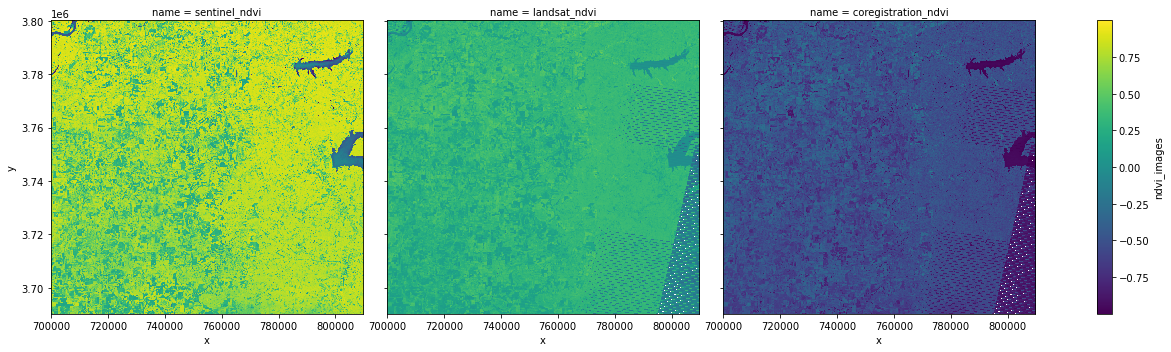

In [13]:
ndvi_imgs = xr.concat(
    [sentinel_ndvi, landsat_ndvi, coregistration_ndvi],
    pd.Index(
        [sentinel_ndvi.name, landsat_ndvi.name, coregistration_ndvi.name], name="name"
    ),
)

ndvi_imgs.name = "ndvi_images"

ndvi_imgs.plot.imshow(x="x", y="y", col="name", figsize=(18, 5), cmap="viridis");